# Counterfactuals in Latent Space

In [175]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../src')
from explainers_lib.explainers.growing_spheres import GrowingSpheresExplainer
from explainers_lib.explainers.wachter import WachterExplainer
from explainers_lib.model import Model as ExplainerModel
from explainers_lib.datasets import Dataset


In [176]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


## Load MNIST data

In [177]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


## Black-box model

### Train CNN model

In [178]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        
        x = self.fc2(x)
        
        return x


In [179]:
cnn_model_path = 'models/torch_cnn_mnist.pth'
if not os.path.exists('models'):
    os.makedirs('models')

cnn = CNN().to(device)
if os.path.exists(cnn_model_path):
    cnn.load_state_dict(torch.load(cnn_model_path))
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    for epoch in range(5):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, CNN Loss: {running_loss / len(train_loader)}')
    torch.save(cnn.state_dict(), cnn_model_path)
cnn.eval()


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Train Autoencoder

In [180]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 16)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(16, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 32 * 7 * 7)
        self.relu2 = nn.ReLU()
        self.t_conv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.relu3 = nn.ReLU()
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = x.view(-1, 32, 7, 7)
        x = self.relu3(self.t_conv1(x))
        x = torch.tanh(self.t_conv2(x))
        return x

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [181]:
ae_model_path = 'models/torch_ae_mnist.pth'
encoder = Encoder().to(device)
decoder = Decoder().to(device)
autoencoder = Autoencoder(encoder, decoder).to(device)

if os.path.exists(ae_model_path):
    autoencoder.load_state_dict(torch.load(ae_model_path))
else:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    for epoch in range(10):
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, AE Loss: {running_loss / len(train_loader)}')
    torch.save(autoencoder.state_dict(), ae_model_path)
autoencoder.eval()


Epoch 1, AE Loss: 0.20690698163913512
Epoch 2, AE Loss: 0.0768549393719511
Epoch 3, AE Loss: 0.05773555587873911
Epoch 4, AE Loss: 0.05083576144614835
Epoch 5, AE Loss: 0.04720730350803592
Epoch 6, AE Loss: 0.04489842605298516
Epoch 7, AE Loss: 0.04321466193699252
Epoch 8, AE Loss: 0.04190547802825091
Epoch 9, AE Loss: 0.04088344433700352
Epoch 10, AE Loss: 0.039923727361441674


Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=1568, out_features=128, bias=True)
    (relu3): ReLU()
    (fc2): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=128, out_features=1568, bias=True)
    (relu2): ReLU()
    (t_conv1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (relu3): ReLU()
    (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)

## Generate Counterfactuals in Latent Space

In [182]:
class BatchedLatentWrapper(ExplainerModel):
    def __init__(self, decoder, cnn, device):
        self.decoder = decoder
        self.cnn = cnn
        self.device = device

    def predict(self, data: Dataset) -> np.ndarray:
        latent_tensors = torch.tensor(data.data, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            decoded_images = self.decoder(latent_tensors)
            predictions = self.cnn(decoded_images)
            predicted_classes = torch.argmax(predictions, dim=1)
            
        return predicted_classes.cpu().numpy()


In [183]:
iteracja = iter(test_loader)


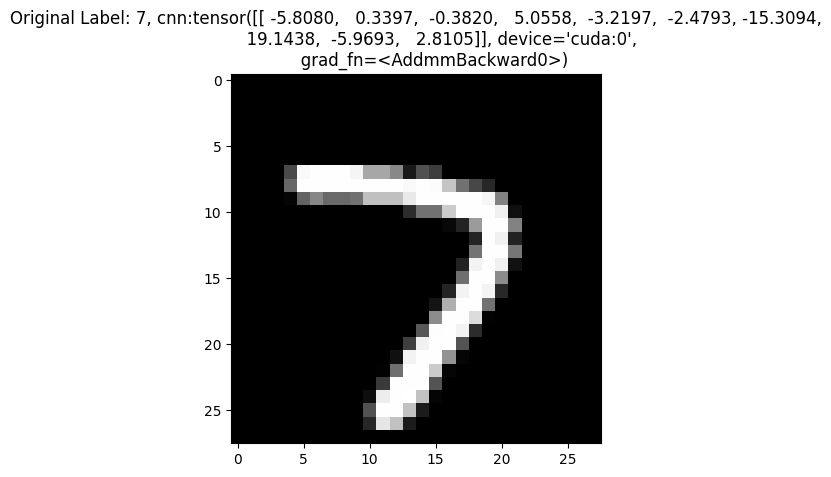

In [208]:
_ = next(iteracja)

images, labels = next(iteracja)
instance_to_explain = images[0:1].to(device)
original_label = labels[0].item()

plt.imshow(instance_to_explain.cpu().squeeze().numpy(), cmap='gray')
plt.title(f'Original Label: {original_label}, cnn:{cnn(images[0:1].to(device))}')
plt.show()


In [209]:
latent_wrapper = BatchedLatentWrapper(decoder, cnn, device)
explainer = GrowingSpheresExplainer(step_size=0.1, num_samples=20, max_radius=1000.0)

explainer.fit(latent_wrapper, Dataset(
    data=test_dataset.data.numpy().reshape(-1, 28*28),
    target=test_dataset.targets.numpy(),
    features=[],
    categorical_features=[],
    continuous_features=[],
    immutable_features=[],
    allowable_ranges=[]
))

latent_instance = encoder(instance_to_explain)
print(latent_instance)
latent_instance_np = latent_instance.cpu().detach().numpy()

latent_dataset = Dataset(
    data=latent_instance_np,
    target=[original_label],
    features=[f'l{i}' for i in range(16)],
    categorical_features=[],
    continuous_features=[f'l{i}' for i in range(16)],
    immutable_features=[],
    allowable_ranges=[]
)

counterfactuals = explainer.explain(latent_wrapper, latent_dataset)
counterfactuals


tensor([[-1.7242, -1.8989, -2.6307,  1.8959,  3.0615,  4.3797, -4.6482,  7.8177,
         -3.1882, -7.3534, -6.6324, -6.0194, -8.7455, 12.2053, -5.6697, -1.6000]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


1instance [00:00, 10.85instance/s]


[Counterfactual(original_data=array([-1.724156 , -1.8989416, -2.6307352,  1.8959147,  3.0614743,
         4.3797197, -4.648209 ,  7.817717 , -3.1881766, -7.353415 ,
        -6.632376 , -6.019372 , -8.745499 , 12.205322 , -5.6697345,
        -1.6000494], dtype=float32), data=array([-0.12226428,  7.71652372,  0.22152966,  4.43655815,  6.53011248,
         7.011324  ,  6.27219276,  8.14843903, -0.35043413, -2.06867135,
        -6.50959641, -2.8530833 , -4.29831643, 14.94887938,  0.82686933,
         9.96813917]), original_class=np.int64(7), target_class=np.int64(0), explainer='growing_spheres(step_size=0.1, max_radius=1000.0, num_samples=20)')]

Counterfactual predicted class: 0 (target: 0)


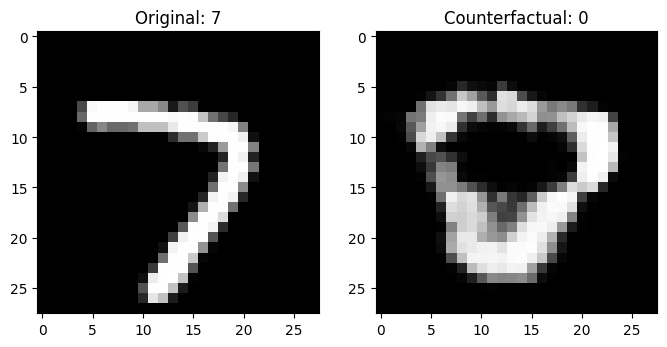

In [210]:
if counterfactuals:
    cf = counterfactuals[0]
    latent_cf = torch.tensor(cf.data, dtype=torch.float32).reshape(latent_instance.shape).to(device)
    preds = latent_wrapper.predict(Dataset(
        data=cf.data,
        target=[cf.target_class],
        features=[f'l{i}' for i in range(16)],
        categorical_features=[],
        continuous_features=[f'l{i}' for i in range(16)],
        immutable_features=[],
        allowable_ranges=[]
    ))
    print(f'Counterfactual predicted class: {preds[0]} (target: {cf.target_class})')
    decoded_cf = decoder(latent_cf)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    ax1.imshow(instance_to_explain.cpu().squeeze().numpy(), cmap='gray')
    ax1.set_title(f'Original: {cf.original_class}')

    ax2.imshow(decoded_cf.cpu().detach().squeeze().numpy(), cmap='gray')
    ax2.set_title(f'Counterfactual: {cf.target_class}')

    plt.show()
else:
    print('No counterfactual found.')
